In [226]:
import os

In [227]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction'

In [228]:
os.chdir("../")

In [229]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [230]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/client-subscription-prediction"
os.chdir(project_dir)

In [231]:
# create the entity
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    """Data Transformation Configuration"""
    root_dir: Path
    data_path: Path
   

In [232]:
from clientClassifier.constants import *
from clientClassifier.utils.common import read_yaml, create_directories

In [233]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config.artifacts_root])
  

    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation
   
        
        # create directories if not exist
        create_directories([config.root_dir])
        
        data_transformation_config = DataTransformationConfig(
            root_dir=  config.root_dir,
            data_path= config.data_path,
        )
        return data_transformation_config

In [234]:
#creating the components
import os
from clientClassifier import logger
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [235]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config

    def initiate_data_transformation(self):
        logger.info(f"Data transformation started")
        
        # read the data
        df = pd.read_csv(self.config.data_path)
        
        # check for missing values
        missing_values = df.isnull().sum()
        if missing_values.any():
            logger.warning(f"Missing values found in the data: {missing_values}")
        else:
            logger.info(f"No missing values found in the data") 
            
        # check for duplicates
        duplicates = df.duplicated().sum()
        if duplicates > 0:
            logger.warning(f"Duplicates found in the data: {duplicates}")
        else:
            logger.info(f"No duplicates found in the data") 
            
        # check for outliers    
        # (this is a simple example, in practice you would use more sophisticated methods)  
        outliers = df.describe()    
        logger.info(f"Outliers in the data: {outliers}")
        
        # check for categorical variables   
        categorical_vars = df.select_dtypes(include=['object']).columns 
        
        if len(categorical_vars) > 0:
            logger.info(f"Categorical variables found in the data: {categorical_vars}")                 
        else:
            logger.info(f"No categorical variables found in the data")      
            
        # check for numerical variables
        numerical_vars = df.select_dtypes(include=['int64', 'float64']).columns 

        if len(numerical_vars) > 0: 
            logger.info(f"Numerical variables found in the data: {numerical_vars}")         
        else:
            logger.info(f"No numerical variables found in the data")

        # check for class imbalance
        class_counts = df['y'].value_counts()      
        logger.info(f"Class distribution in the data: {class_counts}")      
        
        if class_counts.min() / class_counts.max() < 0.2:
            logger.warning(f"Class imbalance found in the data")                
        else:   
            logger.info(f"No class imbalance found in the data")   
            
        
        # convert target variable to binary 
        df['y'] = df['y'].map({'yes': 1, 'no': 0}) 
        
        logger.info(f"Target variable converted to binary")
        
        #exploratory data analysis (EDA)
        df['y'].value_counts().plot(kind='bar')
        plt.title('Target Variable Distribution')   
        plt.xlabel('Target Variable')
        plt.ylabel('Count')
        plt.show()
        
        # check for feature correlation     
        correlation_matrix = df.select_dtypes("number").corr()  
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Feature Correlation Matrix')
        plt.show()
               
        
        logger.info(f"Feature correlation in the data: {correlation_matrix}")           
        
        logger.info("Correlation matrix analysis complete.")

        # General observations
        logger.info("Most features in the dataset show low pairwise correlation, suggesting minimal multicollinearity.")
        logger.info("This is good for tree-based models which are not sensitive to multicollinearity, but may still affect linear models like logistic regression.")

        # Target correlation
        logger.info("'duration' has a very strong positive correlation with the target variable 'y'.")
        logger.info("However, 'duration' is a data leakage feature — it’s only known after the campaign call and directly impacts the prediction.")
        logger.warning("Including 'duration' would artificially inflate model performance. Exclude it during training to ensure real-world generalization.")

        logger.info("Consider removing 'duration' from the feature set to avoid data leakage.")
        logger.info("Features like 'previous' and 'pdays' also show some correlation with the target variable but")  
          
    
    
        # Next step suggestions
        logger.info("Consider conducting feature importance analysis using Random Forest or XGBoost to refine feature selection.")
        
        #drop the 'duration' column
        df.drop(columns=['duration'], inplace=True)
        
        logger.info(f"'duration' column dropped from the data")
        
        # drop the 'Unnamed: 0' column if it exists
        if 'Unnamed: 0' in df.columns:
            df.drop(columns=['Unnamed: 0'], inplace=True)
            logger.info(f"'Unnamed: 0' column dropped from the data")
        else:
            logger.info(f"'Unnamed: 0' column not found in the data")
            
        #drop the 'pdays' column if it exists
        if 'pdays' in df.columns:
            df.drop(columns=['pdays'], inplace=True)
            logger.info(f"'pdays' column dropped from the data")
        else:
            logger.info(f"'pdays' column not found in the data")    
            
            
                
        
        
        
        
        #return df
                
                              
        
        # split the data into train and test sets
    def split_data(self, df):
        logger.info(f"Splitting data into train and test sets")
        train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
        
        # save the train and test sets to csv files
        train_set.to_csv(os.path.join(self.config.root_dir, "train.csv"), index=False)
        test_set.to_csv(os.path.join(self.config.root_dir, "test.csv"), index=False)
        
        logger.info(f"Train and test sets saved to {self.config.root_dir}")
        logger.info(f"Train set shape: {train_set.shape}")
        logger.info(f"Test set shape: {test_set.shape}")
        logger.info(f"Data transformation completed")
        
        print(f"Train set shape: {train_set.shape}")    
        print(f"Test set shape: {test_set.shape}")
        print(f"Data transformation completed")
        
        
        return train_set, test_set
    

[2025-04-10 23:23:19,554: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-04-10 23:23:19,557: INFO: common: yaml file: params.yaml loaded successfully]
[2025-04-10 23:23:19,563: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-04-10 23:23:19,566: INFO: common: created directory at: artifacts]
[2025-04-10 23:23:19,568: INFO: common: created directory at: artifacts/data_transformation]
[2025-04-10 23:23:19,569: INFO: 428772460: Data transformation started]
[2025-04-10 23:23:19,595: INFO: 428772460: No missing values found in the data]
[2025-04-10 23:23:19,609: INFO: 428772460: No duplicates found in the data]
[2025-04-10 23:23:19,635: INFO: 428772460: Outliers in the data:                age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.85663

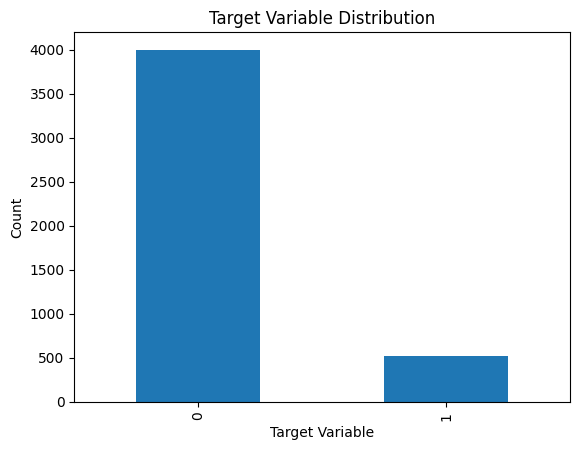

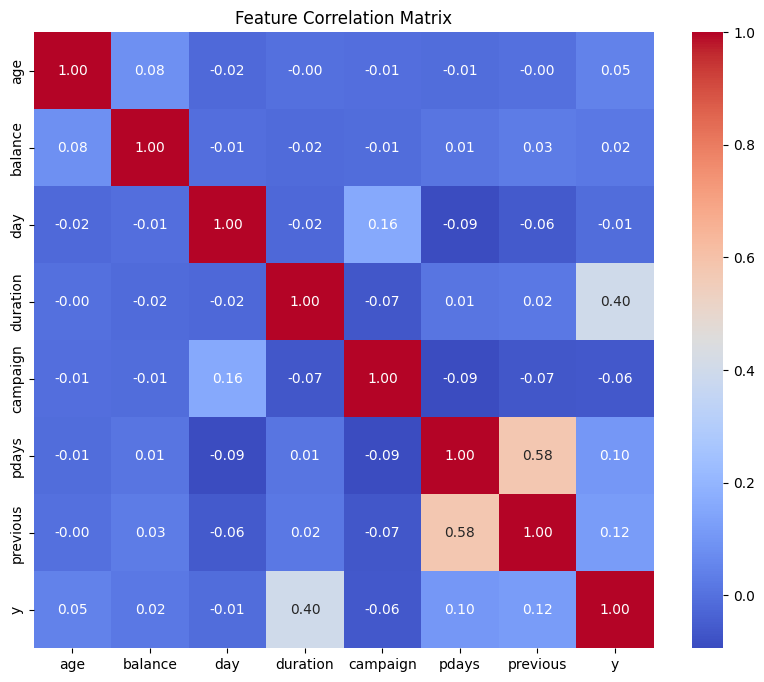

[2025-04-10 23:23:20,064: INFO: 428772460: Feature correlation in the data:                age   balance       day  duration  campaign     pdays  \
age       1.000000  0.083820 -0.017853 -0.002367 -0.005148 -0.008894   
balance   0.083820  1.000000 -0.008677 -0.015950 -0.009976  0.009437   
day      -0.017853 -0.008677  1.000000 -0.024629  0.160706 -0.094352   
duration -0.002367 -0.015950 -0.024629  1.000000 -0.068382  0.010380   
campaign -0.005148 -0.009976  0.160706 -0.068382  1.000000 -0.093137   
pdays    -0.008894  0.009437 -0.094352  0.010380 -0.093137  1.000000   
previous -0.003511  0.026196 -0.059114  0.018080 -0.067833  0.577562   
y         0.045092  0.017905 -0.011244  0.401118 -0.061147  0.104087   

          previous         y  
age      -0.003511  0.045092  
balance   0.026196  0.017905  
day      -0.059114 -0.011244  
duration  0.018080  0.401118  
campaign -0.067833 -0.061147  
pdays     0.577562  0.104087  
previous  1.000000  0.116714  
y         0.116714  1.00000

In [236]:
#define the pipeline
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config() 
    data_transformation = DataTransformation(config=data_transformation_config)
    data_transformation.initiate_data_transformation()
    data_transformation.split_data(df)
    print("Data transformation completed successfully") 
except Exception as e:
    logger.exception(e)
    print(e)    